In [1]:
import pandas as pd
import numpy as np
import tqdm
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

pd.set_option("max_rows", 200)
pd.set_option("max_columns", 50)
tqdm.tqdm.pandas()
%matplotlib inline

In [2]:
df = pd.read_pickle("../input/riiid-test-answer-prediction/split10/train_0.pickle").sort_values(["user_id", "timestamp"]).reset_index(drop=True)

In [3]:
import sys
sys.path.append("..")

In [4]:
from feature_engineering.feature_factory import UserContentRateEncoder, FeatureFactoryManager
from experiment.common import get_logger

In [5]:

feature_factory_dict = {"user_id": {}, ("user_id", "part"): {}}
logger = get_logger()
feature_factory_dict["user_id"]["UserContentRateEncoder"] = UserContentRateEncoder(column="user_id",
                                                                                   rate_func="elo")
feature_factory_dict[("user_id", "part")] = {
    "UserContentRateEncoder": UserContentRateEncoder(column=["user_id", "part"],
                                                     rate_func="elo")
}

feature_factory_manager = FeatureFactoryManager(feature_factory_dict=feature_factory_dict,
                                                logger=logger,
                                                split_num=10,
                                                model_id="train_0",
                                                load_feature=True,
                                                save_feature=True)

In [6]:
import sys
sys.path.append("../")
# df = pd.read_pickle("../input/riiid-test-answer-prediction/split10/train_0.pickle")
df = df.sort_values(["user_id", "timestamp"])
# large_user_id = df["user_id"].value_counts()
# large_user_id = large_user_id[large_user_id > 1000] 
# df = df[df["user_id"].isin(large_user_id.index)]
# df = df[df["answered_correctly"] != -1]

In [7]:
df["answered_correctly"] = df["answered_correctly"].replace(-1, np.nan)

In [8]:
df = feature_factory_manager.all_predict(df)

2020-12-07 20:51:35,756|INFO| load_feature from ../input/feature_engineering/user_content_rate_encoder_user_id_elo_rate_dict.pickle/model_id_train_0.pickle
2020-12-07 20:51:35,995|INFO| load_feature from ../input/feature_engineering/user_content_rate_encoder_['user_id', 'part']_elo_rate_dict.pickle/model_id_train_0.pickle


In [10]:
df_oof_lgbm = pd.read_csv("../output/ex_172/20201202080625/oof_train_0_lgbm.csv")
df_oof_lgbm.columns = ["index", "predict", "target"]

In [11]:
df = pd.merge(df.reset_index(), df_oof_lgbm, how="left")

In [12]:
df["diff_target"] = df["target"] - df["predict"]

findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans.


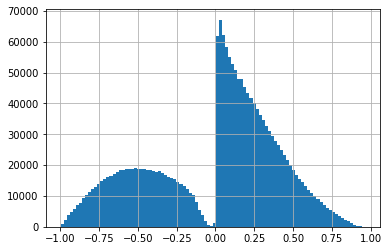

In [13]:
df["diff_target"].hist(bins=100)

In [14]:
df[df["diff_target"] < -0.9].head(10)

,index,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,...,content_rating,user_id_rating,rating_diff_content_user_id,"['user_id', 'part']_rating","rating_diff_content_['user_id', 'part']",user_id_rating_bin,content_rating_bin,predict,target,diff_target
1131,1131,20370167464,138650,3990,0,782,2,0.0,27000.0,True,...,1517,1670,-153,1726,-234,16,15,0.901000,0.0,-0.901000
3239,3239,1585533801,475020,7001,0,542,0,0.0,37333.0,True,...,1174,1632,-458,1564,-435,16,11,0.931124,0.0,-0.931124
4624,4624,1226066296,1173490,8369,0,272,0,0.0,7000.0,True,...,1337,1691,-354,1605,-281,16,13,0.937672,0.0,-0.937672
4973,4973,2547611731,1232090,3017,0,229,2,0.0,27666.0,True,...,1331,1727,-396,1598,-338,17,13,0.945220,0.0,-0.945220
11849,11849,16228032920,1283420,2865,0,4753,1,0.0,21000.0,True,...,1025,1766,-741,1696,-727,17,10,0.994002,0.0,-0.994002
11928,11928,16390234040,1283420,2905,0,4813,0,0.0,21000.0,True,...,1194,1755,-561,1682,-549,17,11,0.956235,0.0,-0.956235
11946,11946,16420932589,1283420,10503,0,4826,0,0.0,33000.0,True,...,1300,1679,-379,1803,-507,16,13,0.944939,0.0,-0.944939
12000,12000,16479214422,1283420,3061,0,4861,0,0.0,22666.0,True,...,1436,1741,-305,1665,-278,17,14,0.931843,0.0,-0.931843
12184,12184,16793992538,1283420,3262,0,5001,3,0.0,27333.0,True,...,1136,1767,-631,1690,-592,17,11,0.963920,0.0,-0.963920
12286,12286,17159466484,1283420,2163,0,5079,2,0.0,25333.0,True,...,1280,1778,-498,1815,-582,17,12,0.939501,0.0,-0.939501


In [17]:
df[df["user_id"]==1283420].to_csv("046_predict_miss/1283420.csv")

In [26]:
df.drop_duplicates("content_id")[df["content_type_id"]==0].groupby("part")["content_rating"].describe()

/home/owner/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,count,mean,std,min,25%,50%,75%,max
part,,,,,,,,
1,984.0,1229.190041,190.340882,617.0,1123.00,1222.0,1345.25,1775.0
2,1644.0,1312.138686,152.938824,807.0,1213.00,1319.0,1415.00,1800.0
3,1553.0,1326.875724,174.358861,686.0,1211.00,1327.0,1447.00,1807.0
4,1432.0,1360.474162,187.236147,814.0,1240.75,1357.0,1486.00,1913.0
5,5485.0,1404.148769,166.394697,835.0,1287.00,1407.0,1522.00,1940.0
6,1200.0,1380.128333,183.957782,839.0,1255.75,1372.0,1501.00,1982.0
7,1154.0,1369.714038,170.833870,911.0,1242.25,1374.0,1486.00,2015.0


/home/owner/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


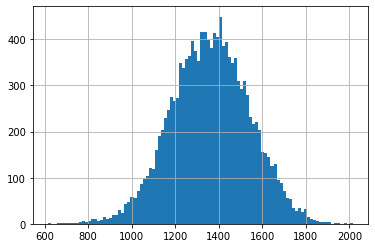

In [27]:
df.drop_duplicates("content_id")[df["content_type_id"]==0]["content_rating"].hist(bins=100)